# Критерии выбора моделей и методы отбора признаков

In [174]:
#%pip install mlxtend

In [175]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [176]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, fetch_california_housing
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from torchvision import datasets
from torchvision import transforms

## Оценка качества моделей

При выборе модели машиного обучения
$$
f: \mathbb{X} \to \mathbb{Y},
$$
модель выбирается согласно некоторого критерия $L$ (функции ошибки, минус логарифм правдоподобия и тд.). Обычно в качестве функции $L$ рассматривается некоторая функция ошибки модели $f$ на выборке $\mathfrak{D}$:
$$
f = \arg\min_{f \in \mathfrak{F}} L\bigr(f, \mathfrak{D}\bigr)
$$

В зависимости от вида функции $L$ разделяют два типа критериев:
1. внутрений критерий качества;
2. внешний критерий качества.

Далее будем рассматривать два типа выборок:
1. $\mathfrak{D}$ это вся выборка, которая доступна для выбора модели;
2. $\mathfrak{D}'$ это выборка на которой проверяется качество уже выбраной модели.
3. $\mathfrak{D}^{l_k}_k$ это $k$-я подвыборка выборки $\mathfrak{D}$ размера $l_k$.

In [177]:
# load_boston deprecated

url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
 ]
data = pd.DataFrame(data, columns=feature_names)
data['target'] = target

#D_all = data['data'], data['target']
np.random.seed(0)
X_train, X_test, y_train, y_test = map(lambda x: x.to_numpy(), train_test_split(data[feature_names], data["target"], 
                                                    test_size=300))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((206, 13), (206,), (300, 13), (300,))

### Внутрений критерий:
Простой пример для регрессии:
$$
f = \arg\min_{f\in \mathfrak{F}} \sum_{\left(x, y\right) \in \mathfrak{D}}\left(f(x) - y\right)^2
$$

In [178]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=13, num_layers=0, 
                 hidden_dim=10, output_dim=1, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))  

        self.device = device      
        self.to(device)
        
    def forward(self, input):
        return self.layers(input)

In [179]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron(num_layers=1, 
                   hidden_dim=20,
                   device=device)
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=13, out_features=20, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [180]:
X_train_pt = torch.from_numpy(X_train).float()
X_test_pt = torch.from_numpy(X_test).float()

y_train_pt = torch.from_numpy(y_train).float().view(-1,1)
y_test_pt = torch.from_numpy(y_test).float().view(-1,1)

train_dataset = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
test_dataset = torch.utils.data.TensorDataset(X_test_pt, y_test_pt)

In [181]:
def get_device(tensors):
    for tensor in tensors:
        print(tensor.device)

get_device(train_dataset.tensors)
get_device(test_dataset.tensors)
torch.cuda.is_available()

cpu
cpu
cpu
cpu


True

In [182]:
def testing(model, dataset):
    model.eval()
    generator = torch.utils.data.DataLoader(dataset, 
                                            batch_size=64, pin_memory=True)

    pred = []
    real = []
    for x, y in generator:
        with torch.no_grad():
            x = x.to(model.device)
            y = y.to(model.device)
            pred.extend(model(x).cpu().numpy().tolist())
            real.extend(y.cpu().numpy().tolist())

    return np.sqrt(np.mean((np.array(real) - np.array(pred))**2))

In [183]:
epochs = 1000

optim = torch.optim.Adam(model.parameters(), lr=0.0001,)
loss_function = torch.nn.MSELoss()

list_of_train_error = [testing(model, train_dataset)]
list_of_test_error = [testing(model, test_dataset)]

iterator = tqdm(range(epochs))
for epoch in iterator:
    generator = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                            batch_size=16, pin_memory=True)
    
    for batch_x, batch_y in generator:
        optim.zero_grad()

        model.train()
        output = model(batch_x.to(device))
        loss = loss_function(output, batch_y.to(device))

        loss.backward()
        optim.step()

    list_of_train_error.append(testing(model, train_dataset))
    list_of_test_error.append(testing(model, test_dataset))

    iterator.set_postfix({'train': round(list_of_train_error[-1], 2), 
                          'test':round(list_of_test_error[-1], 2)})

  0%|          | 0/1000 [00:00<?, ?it/s]

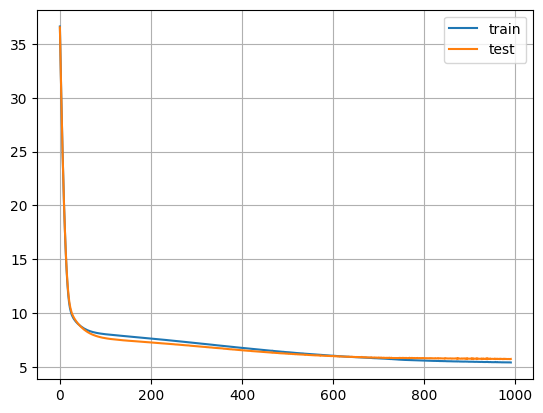

In [184]:
plt.plot(list_of_train_error[10:], label='train')
plt.plot(list_of_test_error[10:], label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

На самом деле выше должна была быть красивая картинка переобучения на реальных данных, но не вышло:( 

Поэтому вставлю синтетический пример с первого семинара.

In [185]:
np.random.seed(0)
l = 6
n = 1
w = np.random.randn(n)
X_tr = np.random.randn(l, n)
y_tr = X_tr@w + np.random.randn(l)

X_vl = np.random.randn(l, n)
y_vl = X_vl@w + np.random.randn(l)

X_ts = np.random.randn(l, n)
y_ts = X_ts@w + np.random.randn(l)

In [186]:
x_begin = -1.05
x_end = 2.5
X_polinom = np.hstack([X_tr**0, X_tr**1, X_tr**2, X_tr**3, X_tr**4, X_tr**5])
w_polinom = np.linalg.inv(X_polinom.T@X_polinom)@X_polinom.T@y_tr
y_polinom = list(map(lambda x: np.array([x**0, x**1, x**2, x**3, x**4, x**5])@w_polinom, 
                     np.linspace(x_begin, x_end)))


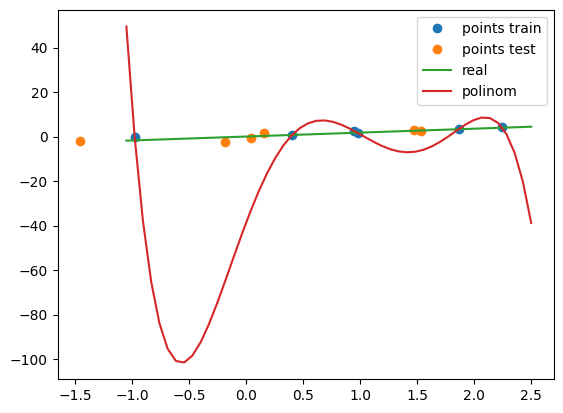

In [187]:
plt.plot(X_tr, y_tr, 'o', label = 'points train')
plt.plot(X_ts, y_ts, 'o', label = 'points test')
plt.plot(np.linspace(x_begin, x_end), w*np.linspace(x_begin, x_end), 
         '-', label = 'real')
plt.plot(np.linspace(x_begin, x_end), y_polinom, '-', label = 'polinom')

plt.legend(loc='best')
plt.show()

Теперь рассмотрим зависимость качества на контроле от числа использованых признаков. Воспользуемся PCA и построем качество от числа главных компонент.

In [188]:
ns = list(range(1, X_train.shape[1]))

scores_train = []
scores_test = []
for n in tqdm(ns):
    pca = PCA(n)
    X_train_low = pca.fit_transform(X_train)
    X_test_low = pca.transform(X_test)

    w = np.linalg.inv(X_train_low.T@X_train_low)@X_train_low.T@y_train

    scores_train.append(np.mean((X_train_low@w - y_train)**2))
    scores_test.append(np.mean((X_test_low@w - y_test)**2))


  0%|          | 0/12 [00:00<?, ?it/s]

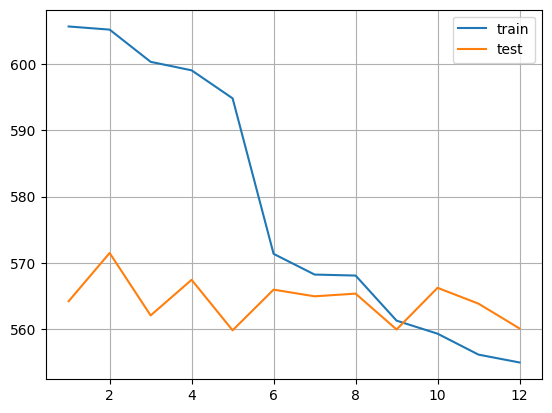

In [189]:
plt.plot(ns, scores_train, label='train')
plt.plot(ns, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Внешний критерий:
1. Разделить выборку $\mathfrak{D}$ на две подвыборки
2. Leave One Out
3. Скользящий контроль
4. Бутсреп
5. Регуляризация
6. Критерий Акаике
7. BIC


## Отбор признаков

Используется два основных подхода
1. Генерация признаков.
2. Отбор существующих признаков.

### Генерация признаков
1. Построение статистик на основе уже существующих признаков и тд.
2. Выше мы использовали PCA, что тоже генерит новые признаки.
3. Нейросеть кроме последнего слоя, также можно рассматривать как метод генерации нового признаково пространства (к примеру прошлое домашнее задание)

### Отбор существующих признаков

#### Полный перебор

В данном случае берем множество всех подмножеств признакового описания.

In [190]:
indexes = list(itertools.product([0, 1], repeat=13))

scores_train = dict()
scores_test = dict()
for i, ind in enumerate(tqdm(indexes)):
    ind = np.array(ind, dtype=bool)

    X_train_low = X_train[:, ind]
    X_test_low = X_test[:, ind]

    w = np.linalg.inv(X_train_low.T@X_train_low)@X_train_low.T@y_train

    scores_train[i] = np.mean((X_train_low@w - y_train)**2)
    scores_test[i] = np.mean((X_test_low@w - y_test)**2)
    

  0%|          | 0/8192 [00:00<?, ?it/s]

In [191]:
best_train = sorted(scores_train, key=lambda x: scores_train[x])[0]
best_test = sorted(scores_test, key=lambda x: scores_test[x])[0]

In [192]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [195]:
print('best for train')
print(indexes[best_train])
selected_features = np.array(feature_names)[np.array(indexes[best_train], dtype=bool)]
print(data[selected_features])

print('best for test')
print(indexes[best_test])
selected_features = np.array(feature_names)[np.array(indexes[best_test], dtype=bool)]
print(data[selected_features])

best for train
(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  

In [ ]:
#print(data['DESCR'][49:1227])
# there is no such column in boston dataset

KeyError: 'DESCR'

In [197]:
scores = []

for i, ind in enumerate(indexes):
    scores.append((sum(ind), scores_train[i]))

scores = np.array(scores)


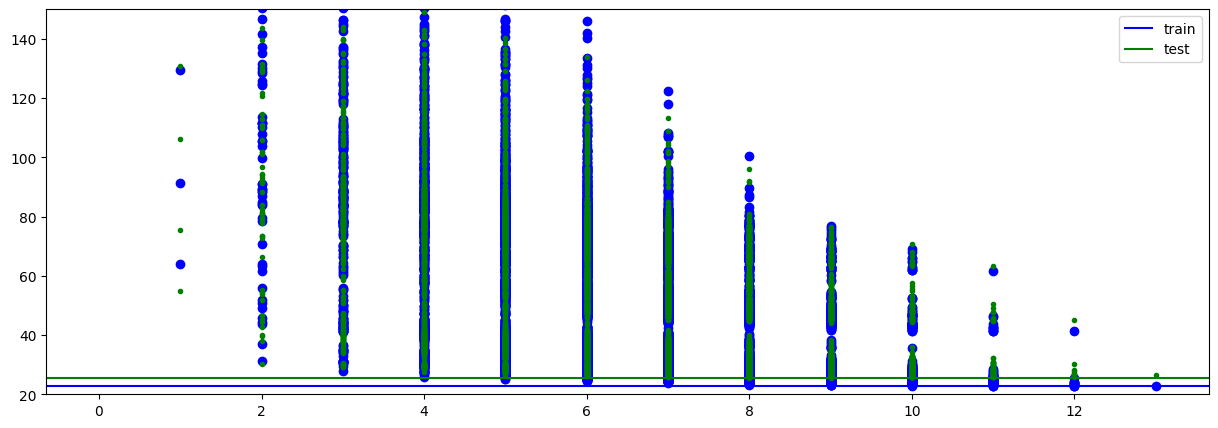

In [198]:
fig = plt.figure(figsize=(15, 5))
scores = np.zeros([len(indexes), 2])
for i, ind in enumerate(indexes):
    scores[i] = [sum(ind), scores_train[i]]
plt.plot(scores[:, 0], scores[:, 1], 'ob')
plt.axhline(y=np.min(scores[:, 1]), color='b', linestyle='-', label = 'train')

for i, ind in enumerate(indexes):
    scores[i] = [sum(ind), scores_test[i]]
plt.plot(scores[:, 0], scores[:, 1], '.g')
plt.axhline(y=np.min(scores[:, 1]), color='g', linestyle='-', label = 'test')

plt.legend(loc='best'), plt.ylim((20, 150))
plt.show()

#### Жадный алгоритм: add

Жадно добавляем один признак, который дает максимальный прирост качества.

In [199]:
np.random.seed(0)
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_train, y_train, test_size=50)


In [200]:
J_star, J, current, k_star, d = [], set(), 99999999999, 0, 1
for k in range(X_val_train.shape[1]):
    scores_val_test = dict()
    for j in list(set(range(X_val_train.shape[1])) - J):
        ind = [ i in (J | {j}) for i in range(X_val_train.shape[1])]
        X_val_train_val = X_val_train[:, ind]
        X_val_test_val = X_val_test[:, ind]
        w = np.linalg.inv(
            X_val_train_val.T@X_val_train_val)@X_val_train_val.T@y_val_train
        scores_val_test[j] = np.mean((X_val_test_val@w - y_val_test)**2)

    best = sorted(scores_val_test, key=lambda x: scores_val_test[x])[0]

    J.add(best)
    
    if scores_val_test[best] < current:
        current = scores_val_test[best]
        k_star = k
        J_star = set(J)
    if k - k_star > d:
        break
ind = np.array([ i in J_star for i in range(X_val_train.shape[1])])

In [202]:
print('best for train')
print(np.array(indexes[best_train], dtype=int))
selected_features = np.array(feature_names)[np.array(indexes[best_train], dtype=bool)]
print(data[selected_features])

print('best for validation')
print(np.array(ind, dtype=int))
selected_features = np.array(feature_names)[np.array(ind, dtype=bool)]
print(data[selected_features])

print('best for test')
print(np.array(indexes[best_test], dtype=int))
selected_features = np.array(feature_names)[np.array(indexes[best_test], dtype=bool)]
print(data[selected_features])

best for train
[1 1 1 1 1 1 1 1 1 1 1 1 1]
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.9

#### Жадный алгоритм: add-del

Реализовать в качестве домашнего задания

# **Сделать**

## Оценка качества классификации

Основные функции для оценки качества классификации:
1. Accuracy (доля верных ответов)
2. Precision (доля релевантных среди всех найденных)
3. Recall (доля найденных среди релевантных)

### Задача 1:
Простая задача бинарной классификации. Прототип алгоритма:

Вход: признаковое описание объекта.

Выход: вероятность класса $1$. (и соответсвенно класс объекта на основе treshold)

Метрики качества:
$$
ACC = \frac{TP + TN}{TP + TN + FP + FN}
$$

$$
PRECISION = \frac{TP}{TP + FP}
$$

$$
RECALL = \frac{TP}{TP + FN}
$$

In [203]:
X, Y = make_classification(n_samples=400, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=100, 
                                                    random_state=0)
X_train_val, X_test_val, Y_train_val, Y_test_val = train_test_split(
    X_train, Y_train, test_size=100, random_state=0)

In [204]:
model = SVC(probability=True)
_ = model.fit(X_train_val, Y_train_val)

fpr, tpr, thresholds = roc_curve(
    Y_test_val, model.predict_proba(X_test_val)[:,1], pos_label=1)

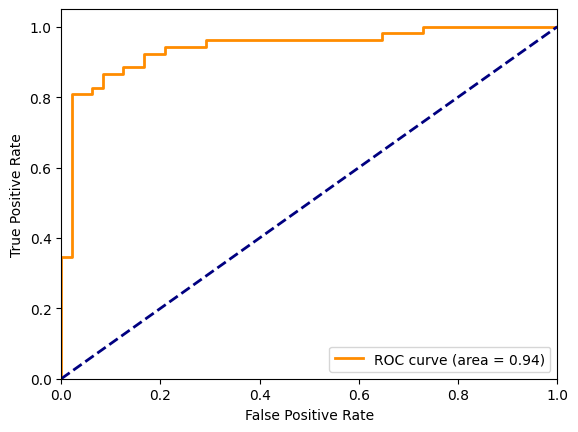

In [205]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {})'.format(round(auc(fpr, tpr), 2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

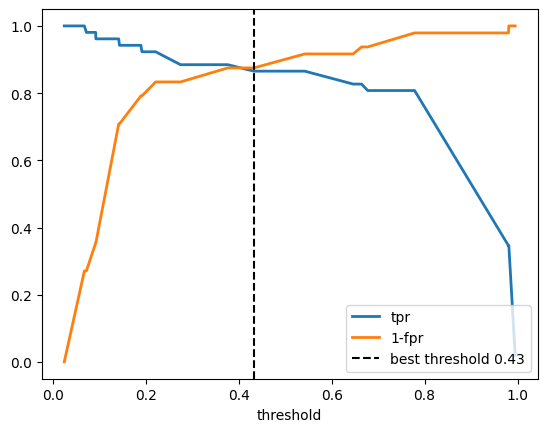

In [206]:
plt.plot(thresholds, tpr, lw = 2, label = 'tpr')
plt.plot(thresholds, 1-fpr, lw = 2, label = '1-fpr')

threshold = thresholds[np.argmin((tpr - 1 + fpr)**2)]
plt.axvline(x=threshold, 
            ls='--', c='black',
            label='best threshold {}'.format(round(threshold, 2)))
plt.xlabel('threshold')
plt.legend(loc="lower right")
plt.show()

In [207]:
print(
    classification_report(
        Y_test, model.predict_proba(X_test)[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        45
           1       0.93      0.78      0.85        55

    accuracy                           0.85       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.86      0.85      0.85       100



In [208]:
print(
    classification_report(
        Y_test, model.predict_proba(X_test)[:, 1] > threshold))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84        45
           1       0.91      0.78      0.84        55

    accuracy                           0.84       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.85      0.84      0.84       100



### Задача 2:
Рассматрим задачу поиска ошибок в тексте. В качестве найденной ошибки выступает фрагмент, который состоит из пары чисел: начало и конец подстроки с ошибкой. Прототип алгоритма очень простой:

Вход: текст.

Выход: список фрагментов, в которых найдена ошибка.

Требуется предложить внешний критерий качества для оценки качества алгоритма. Доступны документы с размеченными фрагментами, а также доступна разметка алгоритма.

В задаче поиска документов используют следующие метрики Precision и Recall:
$$
\text{Precision} = \frac{\left|\{\text{релевантные документы}\} \cap \{\text{найденные документы}\}\right|}{\left|\{\text{найденные документы}\}\right|}
$$

$$
\text{Recall} = \frac{\left|\{\text{релевантные документы}\} \cap \{\text{найденные документы}\}\right|}{\left|\{\text{релевантные документы}\}\right|}
$$


Задания домой: на основе вышеуказаных метрик выписать как Вы би считали метрику для предыдущей задачи.


# **Сделать**

## Как правильно составлять выборки

Большая часть времени занимает построение выборки, которую уже потом требуется аппроксимировать. Правильное составление выборки позволяет решить много проблем в дальнейшем.

Простые правила как правильно составить выборку:
1. Сразу определиться с объектом исследования и целевой переменной.
    * физичиский смысл признаков играет большую роль, так как именно они позволяют интерпретировать результаты модели, поэтому обязательно информацию о физическом смысле каждого признака требется сохранить.
    * если рассматривается задача классификации, то требуется зафиксировать классы, описать эти классы, построить биекцию между классами и их названием физическим описанием.
2. Выполнить разделение выборки на обучение и контроль заранее, убедившись, что они не пересекаются
    * проверить что выборки статистически не различаються.
    * для задачи классификации проверить, что баланс классов в обучении и контроле совпадает.